# **MOVIE RECOMMENDATION SYSTEM USING DEEP REINFORCEMENT LEARNING**


Team :

*  18PD05 : Bharathi A
*  18PD33 : Shreenidhi N




Reference : 

*   https://arxiv.org/pdf/1801.00209.pdf

##**1. Importing Required libraries**

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
import os
# os.chdir('/content/drive/MyDrive/RL/Final Package')
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [8]:
# %tensorflow_version 1.x

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import itertools
import random
import csv

import tensorflow as tf
import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout


In [10]:
tf.__version__

'1.15.2'

## **2. Data Extraction and Loading**

**The MovieLens dataset containing a set of movie ratings from the MovieLens website is used for recommendation**

In [11]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

--2025-04-29 15:16:48--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  1.29MB/s    in 4.1s    

2025-04-29 15:16:53 (1.15 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



###**Preprocessing the MovieLens dataset**

1.  Reading the dataset of user and items(movies)
2.  Preprocess to create a row corresponding to a rate given by a user to a movie
3.  Grouping of all ratings given by users, storing from old(historic) to latest rating based on time
4. Spliting the data into train and test sets, users in test set are not present in the train set and vice versa. Unique users are present in both the sets.
5. Saving the Train and Test data in the CSV format needed for further analysis. Format followed:  
    1. rows : item_id with ratings (combined with &)
    2. columns : state, rewards for actions, n_state

In [12]:
class DataGenerator():


  def __init__(self, path_to_data, path_to_item):
    '''
    Get the Movie lens data with the list of users, the movies(items) and their history
    '''
    self.data  = self.load_data(path_to_data, path_to_item)
    self.users = self.data['userId'].unique()   
    self.items = self.data['itemId'].unique()   
    self.histo = self.generate_history_funtion()
    self.train = []
    self.test  = []

  def load_data(self, path_to_data, path_to_item):
    '''
    Load the data
    '''
    data = pd.read_csv(path_to_data, sep='\t', 
                       names=['userId', 'itemId', 'rating', 'timestamp'])
    movie_titles = pd.read_csv(path_to_item, sep='|', names=['itemId', 'itemName'],
                           usecols=range(2), encoding='latin-1')
    return data.merge(movie_titles,on='itemId', how='left')


  def generate_history_funtion(self):
    '''
    Group all rates given by users and store them from older to most recent based on time.
    '''
    historic_users = []
    for i, u in enumerate(self.users):
      temp = self.data[self.data['userId'] == u]
      temp = temp.sort_values('timestamp').reset_index()
      temp.drop('index', axis=1, inplace=True)
      historic_users.append(temp)
    return historic_users

  def sample_history(self, user_histo, action_ratio=0.8, max_samp_by_user=5,  max_state=100, max_action=50, nb_states=[], nb_actions=[]):
    '''
    Making multiple samples for a given historic set, based on some number of states and actions
    '''

    n = len(user_histo)
    sep = int(action_ratio * n)
    nb_sample = random.randint(1, max_samp_by_user)
    if not nb_states:
      nb_states = [min(random.randint(1, sep), max_state) for i in range(nb_sample)]
    if not nb_actions:
      nb_actions = [min(random.randint(1, n - sep), max_action) for i in range(nb_sample)]
    assert len(nb_states) == len(nb_actions), 'Given array must have the same size'
    
    states  = []
    actions = []
    
    for i in range(len(nb_states)):
      sample_states = user_histo.iloc[0:sep].sample(nb_states[i])
      sample_actions = user_histo.iloc[-(n - sep):].sample(nb_actions[i])
      
      sample_state =  []
      sample_action = []
      for j in range(nb_states[i]):
        row   = sample_states.iloc[j]
        # FORMAT STATE
        state = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
        sample_state.append(state)
      
      for j in range(nb_actions[i]):
        row  = sample_actions.iloc[j]
        # FORMAT ACTION
        action = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
        sample_action.append(action)

      states.append(sample_state)
      actions.append(sample_action)
    return states, actions

  def get_train_test_split(self, test_ratio, seed=None):
    '''
    Create train and test datasets
    '''
    n = len(self.histo)

    if seed is not None:
      random.Random(seed).shuffle(self.histo)
    else:
      random.shuffle(self.histo)

    self.train = self.histo[:int((test_ratio * n))]
    self.test  = self.histo[int((test_ratio * n)):]
    self.user_train = [h.iloc[0,0] for h in self.train]
    self.user_test  = [h.iloc[0,0] for h in self.test]
    

  def write_csv(self, filename, histo_to_write, delimiter=';', action_ratio=0.8, max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
    
    with open(filename, mode='w') as file:
      f_writer = csv.writer(file, delimiter=delimiter)
      f_writer.writerow(['state', 'action_reward', 'n_state'])
      for user_histo in histo_to_write:
        states, actions = self.sample_history(user_histo, action_ratio, max_samp_by_user, max_state, max_action, nb_states, nb_actions)
        for i in range(len(states)):
          # FORMAT STATE
          state_str   = '|'.join(states[i])
          # FORMAT ACTION
          action_str  = '|'.join(actions[i])
          # FORMAT N_STATE
          n_state_str = state_str + '|' + action_str
          f_writer.writerow([state_str, action_str, n_state_str])


## **3. Generating Embeddings for Movies**

###**Creation of Embedding vector for each movie item**


1.   Embedding vector created for each movie based on the context


2. The embeddings are learnt by training a sequential neural network model, where the weight of hidden states will give the output embeddings

3. Training steps :
  1. Context : a set of historic movies rated for a user with 1 random movie removed
  2. Target : the removed movie from historic list

  3. For multiple targets and its corresponding contexts, the embedding for the target movie is created
  4. Therefore, after training,  each movie gets a corresponding vector representation based the context of occurrence

4. Embeddings of each movie is obtained and saved into a file








In [28]:
class EmbeddingsGenerator:

  def  __init__(self, train_users, data):
    self.train_users = train_users

    self.data = data.sort_values(by=['timestamp'])
   
    self.data['userId'] = self.data['userId'] - 1
    self.data['itemId'] = self.data['itemId'] - 1

    self.user_count = self.data['userId'].max() + 1
    self.movie_count = self.data['itemId'].max() + 1

    self.user_movies = {} #list of rated movies by each user
    for userId in range(self.user_count):
      self.user_movies[userId] = self.data[self.data.userId == userId]['itemId'].tolist()
    self.m = self.define_model()

  def define_model(self, hidden_layer_size=100):
    # adding required layers
    m = Sequential()
    m.add(Dense(hidden_layer_size, input_shape=(1, self.movie_count)))
    m.add(Dropout(0.2))
    m.add(Dense(self.movie_count, activation='softmax'))
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m
  
  def generate_input(self, user_id):
    '''
    Returns a context and a target for the user_id
    '''
    user_movies_count = len(self.user_movies[user_id])
    #picking random movie
    random_index = np.random.randint(0, user_movies_count-1) # -1 avoids taking the last movie
    #set target
    target = np.zeros((1, self.movie_count))
    target[0][self.user_movies[user_id][random_index]] = 1
    #set context
    context = np.zeros((1, self.movie_count))
    context[0][self.user_movies[user_id][:random_index] + self.user_movies[user_id][random_index+1:]] = 1
    return context, target

  def train(self, nb_epochs = 300, batch_size = 10000):
    '''
    Trains the model from train_users's history
    '''
    for i in range(nb_epochs):
      print('%d/%d' % (i+1, nb_epochs))
      batch = [self.generate_input(user_id=np.random.choice(self.train_users) - 1) for _ in range(batch_size)]
      X_train = np.array([b[0] for b in batch])
      y_train = np.array([b[1] for b in batch])
      self.m.fit(X_train, y_train, epochs=1, validation_split=0.5)

  def test(self, test_users, batch_size = 100000):
    '''
    Returns on the test set
    '''
    batch_test = [self.generate_input(user_id=np.random.choice(test_users) - 1) for _ in range(batch_size)]
    X_test = np.array([b[0] for b in batch_test])
    y_test = np.array([b[1] for b in batch_test])
    return self.m.evaluate(X_test, y_test)

  def save_embeddings(self, file_name):
    '''
    Generates a csv file containg the vector embedding for each movie.
    '''
    inp = self.m.input                                           # input placeholder
    outputs = [layer.output for layer in self.m.layers]          # all layer outputs
    functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

    #append embeddings to vectors
    vectors = []
    for movie_id in range(self.movie_count):
      movie = np.zeros((1, 1, self.movie_count))
      movie[0][0][movie_id] = 1
      layer_outs = functor([movie])
      vector = [str(v) for v in layer_outs[0][0][0]]
      vector = '|'.join(vector)
      vectors.append([movie_id, vector])

    #saves as a csv file
    embeddings = pd.DataFrame(vectors, columns=['item_id', 'vectors']).astype({'item_id': 'int32'})
    embeddings.to_csv(file_name, sep=';', index=False)
    # files.download(file_name) 



In [29]:
class Embeddings:
  def __init__(self, item_embeddings):
    self.item_embeddings = item_embeddings
  
  def size(self):
    return self.item_embeddings.shape[1]
  
  def get_embedding_vector(self):
    return self.item_embeddings
  
  def get_embedding(self, item_index):
    return self.item_embeddings[item_index]

  def embed(self, item_list):
    return np.array([self.get_embedding(item) for item in item_list])

###**Functions to help in loading the train and test data and embeddings saved**

In [30]:
def file_reading(data_path):
  ''' Load data from train.csv or test.csv. '''

  data = pd.read_csv(data_path, sep=';')
  for col in ['state', 'n_state', 'action_reward']:
    data[col] = [np.array([[np.int(k) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
  for col in ['state', 'n_state']:
    data[col] = [np.array([e[0] for e in l]) for l in data[col]]

  data['action'] = [[e[0] for e in l] for l in data['action_reward']]
  data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
  data.drop(columns=['action_reward'], inplace=True)

  return data

def embeddings_reading(embeddings_path):
  ''' Load embeddings (a vector for each item). '''
  
  embeddings = pd.read_csv(embeddings_path, sep=';')

  return np.array([[np.float64(k) for k in e.split('|')]
                   for e in embeddings['vectors']])

## **4. Environment Simulator**

###**Modelling the recommendation problem as MDP : Markov Decision Process**
1. The states, actions, rewards, trainsition probabilities, discount factor are defined
  1. States S : The previously rated set of moveis sorted with respect to time ( old to latest ratings) for a user
  2. Actions A : Recommend a list of items to a user at time t based on current state
  3. Reward R : based on the rating given by the user
  4. Transition probabilities :  the probability of state transition from st to st+1 for taking action at.
  5. Discount factor : value lying between 0 and 1

In [31]:
class Environment():

  def __init__(self, data, embeddings, alpha, gamma, fixed_length):

    self.embeddings = embeddings
    self.embedded_data = pd.DataFrame()
    self.embedded_data['state'] = [np.array([embeddings.get_embedding(item_id) 
      for item_id in row['state']]) for _, row in data.iterrows()]
    self.embedded_data['action'] = [np.array([embeddings.get_embedding(item_id) 
      for item_id in row['action']]) for _, row in data.iterrows()]
    self.embedded_data['reward'] = data['reward']

    self.alpha = alpha # α (alpha) 
    self.gamma = gamma # Γ (Gamma) 
    self.fixed_length = fixed_length
    self.current_state = self.reset()
    self.groups = self.get_groups()

  def reset(self):
    self.init_state = self.embedded_data['state'].sample(1).values[0]
    return self.init_state

  def step(self, actions):
    '''
    Compute reward and update state 
    '''
    # Compute overall reward r_t
    simulated_rewards, cumulated_reward = self.simulate_rewards(self.current_state.reshape((1, -1)), actions.reshape((1, -1)))

    # Set s_t+1 = s_t <=> self.current_state = self.current_state

    for k in range(len(simulated_rewards)): # '12: for k = 1, K do'
      if simulated_rewards[k] > 0: # '13: if r_t^k > 0 then'
        # '14: Add a_t^k to the end of s_t+1'
        self.current_state = np.append(self.current_state, [actions[k]], axis=0)
        if self.fixed_length: # '15: Remove the first item of s_t+1'
          self.current_state = np.delete(self.current_state, 0, axis=0)

    return cumulated_reward, self.current_state

  def get_groups(self):
    ''' Calculate average state/action value for each group '''

    groups = []
    for rewards, group in self.embedded_data.groupby(['reward']):
      size = group.shape[0]
      states = np.array(list(group['state'].values))
      actions = np.array(list(group['action'].values))
      groups.append({
        'size': size, # N_x in article
        'rewards': rewards, # U_x in article (combination of rewards)
        'average state': (np.sum(states / np.linalg.norm(states, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)), # s_x^-
        'average action': (np.sum(actions / np.linalg.norm(actions, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)) # a_x^-
      })
    return groups

  def simulate_rewards(self, current_state, chosen_actions, reward_type='grouped cosine'):
    '''
    Calculate simulated rewards
    '''
    def cosine_state_action(s_t, a_t, s_i, a_i):
      cosine_state = np.dot(s_t, s_i.T) / (np.linalg.norm(s_t, 2) * np.linalg.norm(s_i, 2))
      cosine_action = np.dot(a_t, a_i.T) / (np.linalg.norm(a_t, 2) * np.linalg.norm(a_i, 2))
      return (self.alpha * cosine_state + (1 - self.alpha) * cosine_action).reshape((1,))

    if reward_type == 'normal':
      # Calculate simulated reward 
      probabilities = [cosine_state_action(current_state, chosen_actions, row['state'], row['action'])
        for _, row in self.embedded_data.iterrows()]
    elif reward_type == 'grouped average':
      # Calculate simulated reward by grouped average
      probabilities = np.array([g['size'] for g in self.groups]) *\
        [(self.alpha * (np.dot(current_state, g['average state'].T) / np.linalg.norm(current_state, 2))\
        + (1 - self.alpha) * (np.dot(chosen_actions, g['average action'].T) / np.linalg.norm(chosen_actions, 2)))
        for g in self.groups]
    elif reward_type == 'grouped cosine':
      # Calculate simulated reward by grouped cosine
      probabilities = [cosine_state_action(current_state, chosen_actions, g['average state'], g['average action'])
        for g in self.groups]

    # Normalizing
    probabilities = np.array(probabilities) / sum(probabilities)

    # Get most probable rewards
    if reward_type == 'normal':
      returned_rewards = self.embedded_data.iloc[np.argmax(probabilities)]['reward']
    elif reward_type in ['grouped average', 'grouped cosine']:
      returned_rewards = self.groups[np.argmax(probabilities)]['rewards']

    
    def overall_reward(rewards, gamma):
      return np.sum([gamma**k * reward for k, reward in enumerate(rewards)])

    if reward_type in ['normal', 'grouped average']:
      # Get cumulated reward
      cumulated_reward = overall_reward(returned_rewards, self.gamma)
    elif reward_type == 'grouped cosine':
      # Get probability weighted cumulated reward
      cumulated_reward = np.sum([p * overall_reward(g['rewards'], self.gamma)
        for p, g in zip(probabilities, self.groups)])

    return returned_rewards, cumulated_reward


##**5. Actor**

###**The actor framework created**

2 steps in the framework : A state-specific scoring function, which rates items according to
user’s current state; instead of just considering the average.
1. State-specific scoring function parameter generating. 
2. action generating.


Recommendation of a list of movies. Here the output are the corresponding embeddings of the movies recommended.

In [32]:
class Actor():
  ''' Policy function approximator '''
  
  def __init__(self, sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embedding_size, tau, learning_rate, scope='actor'):
    self.sess = sess
    self.state_space_size = state_space_size
    self.action_space_size = action_space_size
    self.batch_size = batch_size
    self.ra_length = ra_length
    self.history_length = history_length
    self.embedding_size = embedding_size
    self.tau = tau
    self.learning_rate = learning_rate
    self.scope = scope

    with tf.variable_scope(self.scope):
      # Build Actor network
      self.action_weights, self.state, self.sequence_length = self._build_net('estimator_actor')
      self.network_params = tf.trainable_variables()

      # Build target Actor network
      self.target_action_weights, self.target_state, self.target_sequence_length = self._build_net('target_actor')
      self.target_network_params = tf.trainable_variables()[len(self.network_params):] # TODO: why sublist [len(x):]? Maybe because its equal to network_params + target_network_params

      # Initialize target network weights with network weights (θ^π′ ← θ^π)
      self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
        for i in range(len(self.target_network_params))]
        
      # Update target network weights (θ^π′ ← τθ^π + (1 − τ)θ^π′)
      self.update_target_network_params = [self.target_network_params[i].assign(
        tf.multiply(self.tau, self.network_params[i]) +
        tf.multiply(1 - self.tau, self.target_network_params[i]))
        for i in range(len(self.target_network_params))]

      # Gradient computation from Critic's action_gradients
      self.action_gradients = tf.placeholder(tf.float32, [None, self.action_space_size])
      gradients = tf.gradients(tf.reshape(self.action_weights, [self.batch_size, self.action_space_size], name='42222222222'),
                               self.network_params,
                               self.action_gradients)
      params_gradients = list(map(lambda x: tf.div(x, self.batch_size * self.action_space_size), gradients))
      
      # Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s)
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(
          zip(params_gradients, self.network_params))

  def _build_net(self, scope):
    ''' Build the (target) Actor network '''

    def gather_last_output(data, seq_lens):
      def cli_value(x, v):
        y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
        x = tf.cast(x, tf.int64)
        return tf.where(tf.greater(x, y), x, y)

      batch_range = tf.range(tf.cast(tf.shape(data)[0], dtype=tf.int64), dtype=tf.int64)
      tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
      indices = tf.stack([batch_range, tmp_end], axis=1)
      return tf.gather_nd(data, indices)

    with tf.variable_scope(scope):
     
      state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
      state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
      sequence_length = tf.placeholder(tf.int32, [None], 'sequence_length')
      cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
      outputs, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
      last_output = gather_last_output(outputs, sequence_length) 
      x = tf.keras.layers.Dense(self.ra_length * self.embedding_size)(last_output)
      action_weights = tf.reshape(x, [-1, self.ra_length, self.embedding_size])

    return action_weights, state, sequence_length

  def train(self, state, sequence_length, action_gradients):
    '''  Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s). '''
    self.sess.run(self.optimizer,
                  feed_dict={
                      self.state: state,
                      self.sequence_length: sequence_length,
                      self.action_gradients: action_gradients})

  def predict(self, state, sequence_length):
    return self.sess.run(self.action_weights,
                         feed_dict={
                             self.state: state,
                             self.sequence_length: sequence_length})

  def predict_target(self, state, sequence_length):
    return self.sess.run(self.target_action_weights,
                         feed_dict={
                             self.target_state: state,
                             self.target_sequence_length: sequence_length})

  def init_target_network(self):
    self.sess.run(self.init_target_network_params)

  def update_target_network(self):
    self.sess.run(self.update_target_network_params)
    
  def get_recommendation_list(self, ra_length, noisy_state, embeddings, target=False):
   
    def get_score(weights, embedding, batch_size):
     
      ret = np.dot(weights, embedding.T)
      return ret

    batch_size = noisy_state.shape[0]

    # Generate w_t = {w_t^1, ..., w_t^K} 
    method = self.predict_target if target else self.predict
    weights = method(noisy_state, [ra_length] * batch_size)

    # Score items 
    scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
      for embedding in embeddings.get_embedding_vector()]
      for k in range(ra_length)]
      for i in range(batch_size)])

    return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
      for k in range(ra_length)]
      for i in range(batch_size)])


##**6. Critic**

###**An approximator to learn the action-value function**
1. Necessary for the judgment of whether the
action at generated by Actor matches the current state st
2. Updation of parameters in the direction of improving the performance

In [33]:
class Critic():
  ''' Value function approximator '''
  
  def __init__(self, sess, state_space_size, action_space_size, history_length, embedding_size, tau, learning_rate, scope='critic'):
    self.sess = sess
    self.state_space_size = state_space_size
    self.action_space_size = action_space_size
    self.history_length = history_length
    self.embedding_size = embedding_size
    self.tau = tau
    self.learning_rate = learning_rate
    self.scope = scope

    with tf.variable_scope(self.scope):
      # Build Critic network
      self.critic_Q_value, self.state, self.action, self.sequence_length = self._build_net('estimator_critic')
      self.network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='estimator_critic')

      # Build target Critic network
      self.target_Q_value, self.target_state, self.target_action, self.target_sequence_length = self._build_net('target_critic')
      self.target_network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_critic')

      # Initialize target network weights with network weights (θ^µ′ ← θ^µ)
      self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
        for i in range(len(self.target_network_params))]

      # Update target network weights (θ^µ′ ← τθ^µ + (1 − τ)θ^µ′)
      self.update_target_network_params = [self.target_network_params[i].assign(
        tf.multiply(self.tau, self.network_params[i]) +
        tf.multiply(1 - self.tau, self.target_network_params[i]))
        for i in range(len(self.target_network_params))]

      # Minimize MSE between Critic's and target Critic's outputed Q-values
      self.expected_reward = tf.placeholder(tf.float32, [None, 1])
      self.loss = tf.reduce_mean(tf.squared_difference(self.expected_reward, self.critic_Q_value))
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

      # Compute ∇_a.Q(s, a|θ^µ)
      self.action_gradients = tf.gradients(self.critic_Q_value, self.action)

  def _build_net(self, scope):
    ''' Build the (target) Critic network '''

    def gather_last_output(data, seq_lens):
      def cli_value(x, v):
        y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
        return tf.where(tf.greater(x, y), x, y)

      this_range = tf.range(tf.cast(tf.shape(seq_lens)[0], dtype=tf.int64), dtype=tf.int64)
      tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
      indices = tf.stack([this_range, tmp_end], axis=1)
      return tf.gather_nd(data, indices)

    with tf.variable_scope(scope):
      
      state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
      state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
      action = tf.placeholder(tf.float32, [None, self.action_space_size], 'action')
      sequence_length = tf.placeholder(tf.int64, [None], name='critic_sequence_length')
      cell = tf.nn.rnn_cell.GRUCell(self.history_length,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
      predicted_state, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
      predicted_state = gather_last_output(predicted_state, sequence_length)

      inputs = tf.concat([predicted_state, action], axis=-1)
      layer1 = tf.layers.Dense(32, activation=tf.nn.relu)(inputs)
      layer2 = tf.layers.Dense(16, activation=tf.nn.relu)(layer1)
      critic_Q_value = tf.layers.Dense(1)(layer2)
      return critic_Q_value, state, action, sequence_length

  def train(self, state, action, sequence_length, expected_reward):
    ''' Minimize MSE between expected reward and target Critic's Q-value '''
    return self.sess.run([self.critic_Q_value, self.loss, self.optimizer],
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length,
                             self.expected_reward: expected_reward})

  def predict(self, state, action, sequence_length):
    ''' Returns Critic's predicted Q-value '''
    return self.sess.run(self.critic_Q_value,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})

  def predict_target(self, state, action, sequence_length):
    ''' Returns target Critic's predicted Q-value '''
    return self.sess.run(self.target_Q_value,
                         feed_dict={
                             self.target_state: state,
                             self.target_action: action,
                             self.target_sequence_length: sequence_length})

  def get_action_gradients(self, state, action, sequence_length):
    ''' Returns ∇_a.Q(s, a|θ^µ) '''
    return np.array(self.sess.run(self.action_gradients,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})[0])

  def init_target_network(self):
    self.sess.run(self.init_target_network_params)

  def update_target_network(self):
    self.sess.run(self.update_target_network_params)

##**7. Replay**

###**The states and rewards for transitions are stored**

In [34]:
class ReplayMemory():
  ''' Replay memory D in article '''
  
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.buffer = []

  def add(self, state, action, reward, n_state):
    self.buffer.append([state, action, reward, n_state])
    if len(self.buffer) > self.buffer_size:
      self.buffer.pop(0)

  def size(self):
    return len(self.buffer)

  def sample_batch(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [35]:
def experience_replay(replay_memory, batch_size, actor, critic, embeddings, ra_length, state_space_size, action_space_size, discount_factor):
  '''
  Experience replay
  Best Q-value, loss of Critic network
  '''

  # Sample minibatch of N transitions (s, a, r, s′) from D
  samples = replay_memory.sample_batch(batch_size)
  states = np.array([s[0] for s in samples])
  actions = np.array([s[1] for s in samples])
  rewards = np.array([s[2] for s in samples])
  n_states = np.array([s[3] for s in samples]).reshape(-1, state_space_size)

  # Generate a′ by target Actor network
  n_actions = actor.get_recommendation_list(ra_length, states, embeddings, target=True).reshape(-1, action_space_size)

  # Calculate predicted Q′(s′, a′|θ^µ′) value
  target_Q_value = critic.predict_target(n_states, n_actions, [ra_length] * batch_size)

  # Set y = r + γQ′(s′, a′|θ^µ′)
  expected_rewards = rewards + discount_factor * target_Q_value
  
  # Update Critic by minimizing (y − Q(s, a|θ^µ))²
  critic_Q_value, critic_loss, _ = critic.train(states, actions, [ra_length] * batch_size, expected_rewards)
  
  # Update the Actor using the sampled policy gradient
  action_gradients = critic.get_action_gradients(states, n_actions, [ra_length] * batch_size)
  actor.train(states, [ra_length] * batch_size, action_gradients)

  # Update the Critic target networks
  critic.update_target_network()

  # Update the Actor target network
  actor.update_target_network()

  return np.amax(critic_Q_value), critic_loss

## **8. Training**

###**Using the train data to build and train a model**
1. Parameters are trained
2. Updation of the actor and critic network
3. Saving the trained model


In [36]:
class Noise:
  ''' Noise for Actor predictions '''
  def __init__(self, action_space_size, mu=0, theta=0.5, sigma=0.2):
    self.action_space_size = action_space_size
    self.mu = mu
    self.theta = theta
    self.sigma = sigma
    self.state = np.ones(self.action_space_size) * self.mu

  def get(self):
    self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
    return self.state
    

def train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary):
  
  # Set up summary operators
  def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar('reward', episode_reward)
    episode_max_Q = tf.Variable(0.)
    tf.summary.scalar('max_Q_value', episode_max_Q)
    critic_loss = tf.Variable(0.)
    tf.summary.scalar('critic_loss', critic_loss)

    summary_vars = [episode_reward, episode_max_Q, critic_loss]
    summary_ops = tf.summary.merge_all()
    return summary_ops, summary_vars

  summary_ops, summary_vars = build_summaries()
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter(filename_summary, sess.graph)

  # Initialize target network f′ and Q′
  actor.init_target_network()
  critic.init_target_network()

  # Initialize the capacity of replay memory D
  replay_memory = ReplayMemory(buffer_size) 
  replay = False


  start_time = time.time()
  for i_session in range(nb_episodes): 
    session_reward = 0
    session_Q_value = 0
    session_critic_loss = 0
    #Initialize state s_0 from previous sessions
    states = environment.reset() 
    
    # Update average parameters every 10 episodes
    if (i_session + 1) % 10 == 0: 
      environment.groups = environment.get_groups()
      
    exploration_noise = Noise(history_length * embeddings.size())

    for t in range(nb_rounds): 
      # Stage 1: Transition Generating Stage

      # Select an action a_t = {a_t^1, ..., a_t^K} 
      actions = actor.get_recommendation_list(
          ra_length,
          states.reshape(1, -1), 
          embeddings).reshape(ra_length, embeddings.size())

      # Execute action a_t and observe the reward list {r_t^1, ..., r_t^K} for each item in a_t
      rewards, next_states = environment.step(actions)

      # Store transition (s_t, a_t, r_t, s_t+1) in D
      replay_memory.add(states.reshape(history_length * embeddings.size()),
                        actions.reshape(ra_length * embeddings.size()),
                        [rewards],
                        next_states.reshape(history_length * embeddings.size()))

      # Set s_t = s_t+1
      states = next_states 

      session_reward += rewards
      
      # Stage 2: Parameter Updating Stage
      if replay_memory.size() >= batch_size: # Experience replay
        replay = True
        replay_Q_value, critic_loss = experience_replay(replay_memory, batch_size,
          actor, critic, embeddings, ra_length, history_length * embeddings.size(),
          ra_length * embeddings.size(), discount_factor)
        session_Q_value += replay_Q_value
        session_critic_loss += critic_loss

      summary_str = sess.run(summary_ops,
                             feed_dict={summary_vars[0]: session_reward,
                                        summary_vars[1]: session_Q_value,
                                        summary_vars[2]: session_critic_loss})
      
      writer.add_summary(summary_str, i_session)

    str_loss = str('Loss=%0.4f' % session_critic_loss)
    print(('Episode %d/%d Reward=%d Time=%ds ' + (str_loss if replay else 'No replay')) % (i_session + 1, nb_episodes, session_reward, time.time() - start_time))
    start_time = time.time()

  writer.close()
  tf.train.Saver().save(sess, '../Data/models.h5', write_meta_graph=False)

In [37]:
# Hyperparameters
history_length = 4 # N in article=====12
ra_length = 4 # K in article
discount_factor = 0.99 # Gamma in Bellman equation
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 # τ in Algorithm 3
batch_size = 32 #========128
nb_episodes = 5
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5 # α (alpha) in Equation (1)
gamma = 0.9 # Γ (Gamma) in Equation (4)
buffer_size = 10000 # Size of replay memory D in article ========= 1000000
fixed_length = True # Fixed memory length

dg = DataGenerator('ml-100k/u.data', 'ml-100k/u.item')
dg.get_train_test_split(0.8, seed=42)

dg.write_csv('../Data/train.csv', dg.train, nb_states=[history_length], nb_actions=[ra_length])
dg.write_csv('../Data/test.csv', dg.test, nb_states=[history_length], nb_actions=[ra_length])

data = file_reading('../Data/train.csv')


/home/sranasin/conda/envs/DeepRL/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [38]:
if True: # Generate embeddings?
  eg = EmbeddingsGenerator(dg.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))
  eg.train(nb_epochs=50)
  train_loss, train_accuracy = eg.test(dg.user_train)
  print('Train set: Loss=%.4f ; Accuracy=%.1f%%' % (train_loss, train_accuracy * 100))
  test_loss, test_accuracy = eg.test(dg.user_test)
  print('Test set: Loss=%.4f ; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
  eg.save_embeddings('../Data/embeddings.csv')


1/50
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 6s 1ms/step - loss: 6.9085 - acc: 0.0110 - val_loss: 6.5476 - val_acc: 0.0132
2/50
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 1s 282us/step - loss: 6.4257 - acc: 0.0154 - val_loss: 6.3262 - val_acc: 0.0176
3/50
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 1s 282us/step - loss: 6.2918 - acc: 0.0126 - val_loss: 6.2124 - val_acc: 0.0136
4/50
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 1s 285us/step - loss: 6.2150 - acc: 0.0144 - val_loss: 6.1373 - val_acc: 0.0184
5/50
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 1s 281us/step - loss: 6.1627 - acc: 0.0166 - val_loss: 6.1035 - val_acc: 0.0178
6/50
Train on 5000 samples, validate on 5000 samples
Epoch 1/1

In [39]:
embeddings = Embeddings(embeddings_reading('../Data/embeddings.csv'))

state_space_size = embeddings.size() * history_length
action_space_size = embeddings.size() * ra_length


environment = Environment(data, embeddings, alpha, gamma, fixed_length)

# For multiple consecutive executions
tf.reset_default_graph() 

sess = tf.Session()
# Initialize actor network f_θ^π and critic network Q(s, a|θ^µ) with random weights
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)




Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.









Episode 1/5 Reward=542 Time=19s Loss=1086.9011
Episode 2/5 Reward=542 Time=34s Loss=66.1671
Episode 3/5 Reward=542 Time=33s Loss=14.7715
Episode 4/5 Reward=542 Time=33s Loss=10.4242
Episode 5/5 Reward=542 Time=33s Loss=9.4510



## **9. Testing**

###**Test on the Test dataset**

1. Using the test dataset and movie embeddings saved previously
2. Using the well trained parameters of the final model obtained

In [40]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
  str_item = str(item)
  assert(str_item not in dict_embeddings)
  dict_embeddings[str_item] = i

def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target=False):
  return [dict_embeddings[str(action)]
          for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), embeddings, target).reshape(ra_length, embeddings.size())]

def test_actor(actor, test_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
  ratings = []
  unknown = 0
  random_seen = []
  for _ in range(nb_rounds):
    for i in range(len(test_df)):
      history_sample = list(test_df[i].sample(history_length)['itemId'])
      recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
      for item in recommendation:
        l = list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])
        assert(len(l) < 2)
        if len(l) == 0:
          unknown += 1
        else:
          ratings.append(l[0])
      for item in history_sample:
        random_seen.append(list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])[0])

  return ratings, unknown, random_seen



## **10. Performance Evaluation**

###**Train Set**

Target = False

In [41]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=2)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

95.0% unknown


Comparison between the actual predictions made by the model and the randomly generated predictions

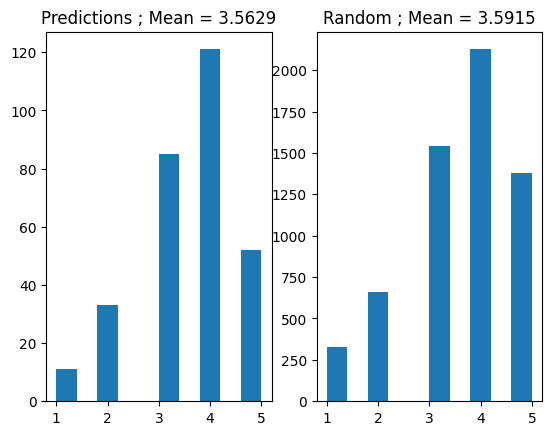

In [42]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

Target = True

In [43]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=2)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

89.7% unknown


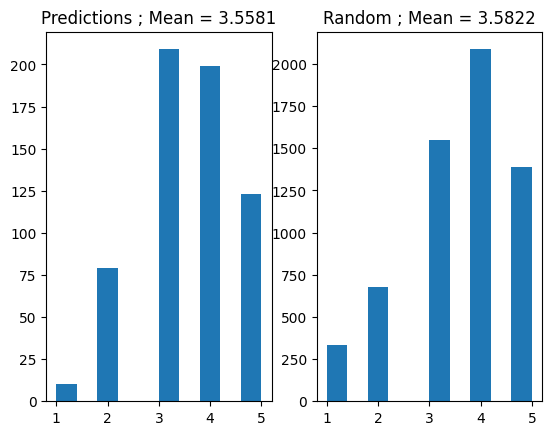

In [44]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

###**Test Set**

Target = False

In [45]:
ratings, unknown, random_seen = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

95.4% unknown


Comparison between the actual predictions made by the model and the randomly generated predictions

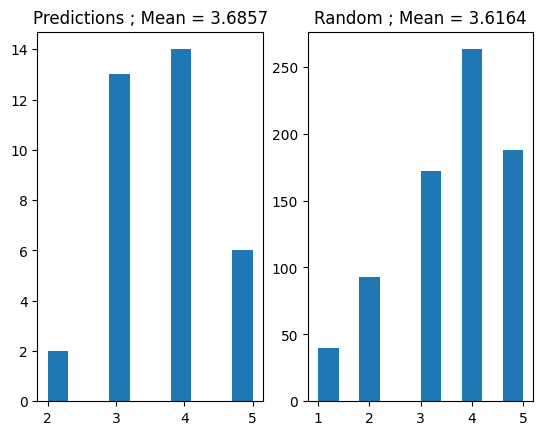

In [46]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

Target = True

In [47]:
ratings, unknown, random_seen = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=2)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

90.7% unknown


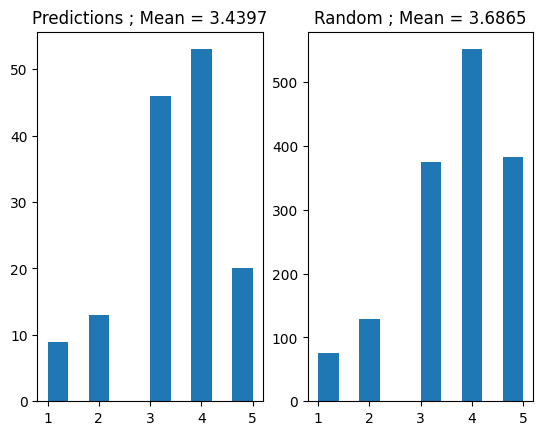

In [48]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()


_______________________________________________________